<img align="left" src=https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=150 style="padding: 5px">
<img align="left" src=https://noirlab.edu/public/media/archives/images/screen640/ann22016a.jpg width=200 style="padding: 5px">
<br>

<b>What's That Streak?</b><br>
A Rubin x SatHub notebook by Meredith Rawls<br>
Last verified to run: June 4, 2025<br>
LSST Science Pipelines version: w_2025_22<br>

### Edit this top cell with the Rubin visit of interest, and run the notebook

The parameter `obsinfo` is a visit ID, which may typically constructed as date_obs + 00 + seq_num.

In [208]:
#obsinfo = 2024111700129
obsinfo = 2025050100289

# LSSTCam
repo = 'embargo'
collections = ['LSSTCam/runs/nightlyValidation']
instrument = 'LSSTCam'

# LSSTComCam
#repo = '/repo/dp1'
#collections = ['LSSTComCam/DP1']
#instrument = 'LSSTComCam'

### You shouldn't need to change anything below, it should "just work"

Only one cell uses Butler-retrieved things, specifically the dataset `preliminary_visit_summary`.

The SatChecker query includes a generous 3 degree radius FOV and a generous duration 3x the exposure time (centered on the exposure midpoint).

To learn more about SatChecker, please visit https://satchecker.readthedocs.io

In [209]:
%matplotlib widget

In [210]:
import astropy.units as u
from astropy.time import Time
import matplotlib.pyplot as plt
import numpy as np
import requests
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook"
import lsst.daf.butler as dafButler

In [211]:
latitude = -30.244633  # deg
longitude = -70.749417  # deg
elevation = 2647  # meters
fov_radius = 3  # FOV query radius, in degrees
# Note LSSTComCam is about 0.67 deg across on the sky ... LSSTCam FOV has a radius of 1.76 deg

In [212]:
butler = dafButler.Butler(repo, collections=collections, instrument=instrument)
pvs = butler.get('preliminary_visit_summary', visit=obsinfo)

# get the center RA and Dec from detector 94, which is in the center of the focal plane
ra_center = pvs['id'==94]['ra']
dec_center = pvs['id'==94]['dec']

# get the start time (JD) and duration (seconds), plus a buffer, for the SatChecker query
exp_time = pvs['id'==94]['expTime']
record = butler.query_dimension_records('visit', where=f'visit={obsinfo}')[0]
exp_begin = record.timespan.begin

# the query time window will go from T0 - Texp to T0 + 2*Texp, for a total duration of 3*Texp
start_time_jd = (exp_begin - exp_time*u.s).jd
duration = (exp_time*u.s * 3).value

In [213]:
# Make the SatChecker API request
url_string = f"https://dev.satchecker.cps.iau.noirlab.edu/fov/satellite-passes/?latitude={latitude}&longitude={longitude}&elevation={elevation}&start_time_jd={start_time_jd}&duration={duration}&ra={ra_center}&dec={dec_center}&fov_radius={fov_radius}&group_by=satellite"
response = requests.get(url_string, timeout=60)
data = response.json()

In [214]:
# Extract RA/Dec positions for each satellite
satellites = {}

for sat_key, sat_data in data['data']['satellites'].items():
    if sat_key not in satellites:
        satellites[sat_key] = []
    # Add ra, dec, and julian_date from each position
    for position in sat_data['positions']:
        satellites[sat_key].append([
            position['ra'],
            position['dec'],
            position['julian_date']
        ])

print(f"Public catalog satellites passing through the specified FOV, as seen from Rubin Observatory, starting at {start_time_jd} JD for {duration} seconds:")
for sat in satellites:
    print(f"{sat}: {len(satellites[sat])} points")

Public catalog satellites passing through the specified FOV, as seen from Rubin Observatory, starting at 2460797.5393731813 JD for 90.00298118591309 seconds:
ARIANE 2 DEB (26717): 9 points
ARIANE 44LP DEB (25540): 91 points
ATLAS 5 CENTAUR DEB (43980): 91 points
BREEZE-M R/B (37934): 33 points
DELTA 4 R/B (39534): 91 points
INTELSAT 902 (26900): 91 points
SBIRS GEO 2 (USA 241) (39120): 91 points
STARLINK-1397 (45682): 5 points
TELECOM 2D (24209): 91 points
THURAYA 1 (26578): 8 points
TITAN 3C TRANSTAGE DEB (38705): 91 points
USA 159 (26880): 56 points


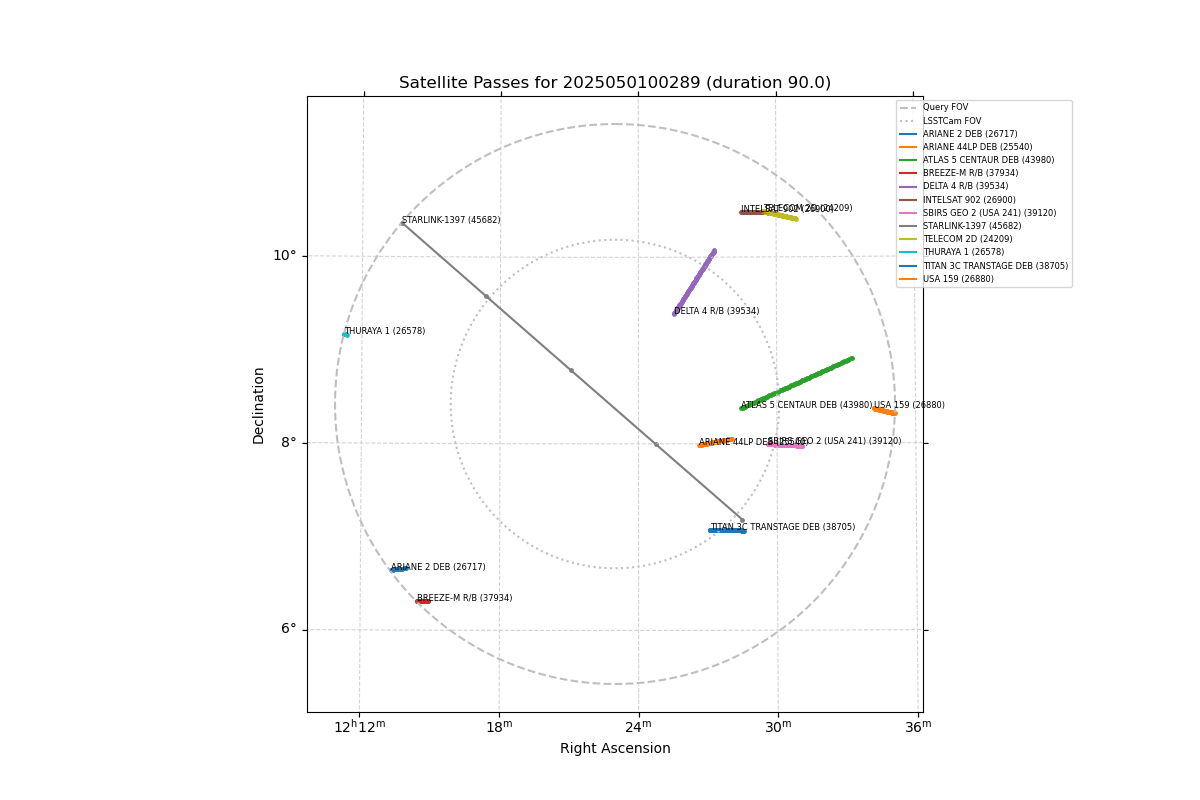

In [215]:
# Simple WCS for the plot
wcs = WCS(naxis=2)
wcs.wcs.crpix = [0, 0]
wcs.wcs.crval = [ra_center, dec_center]
wcs.wcs.cdelt = [0.1, 0.1]
wcs.wcs.ctype = ['RA---TAN', 'DEC--TAN']

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1, projection=wcs)
center = SkyCoord(ra=ra_center*u.deg, dec=dec_center*u.deg, frame='icrs')
position_angles = np.linspace(0, 360, 360) * u.deg
circle_points = center.directional_offset_by(position_angles, fov_radius * u.deg)

# Query FOV
ax.plot(circle_points.ra.deg, circle_points.dec.deg, 
        c='0.75', ls='--', label='Query FOV', transform=ax.get_transform('world'))

# LSSTCam FOV
rubin_fov_radius = 1.761111
rubin_circle_points = center.directional_offset_by(position_angles, rubin_fov_radius * u.deg)
ax.plot(rubin_circle_points.ra.deg, rubin_circle_points.dec.deg,
        c='0.75', ls=':', label='LSSTCam FOV', transform=ax.get_transform('world'))

# Satellite tracks
for sat_name in satellites.keys():
    ra = [pos[0] for pos in satellites[sat_name]]
    dec = [pos[1] for pos in satellites[sat_name]]
    coords = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
    
    # Satellite track
    ax.plot(coords.ra.deg, coords.dec.deg, 
            transform=ax.get_transform('world'),
            label=sat_name)
        
    # Satellite position points
    ax.scatter(coords.ra.deg, coords.dec.deg, 
               transform=ax.get_transform('world'), s=6)
    
    # Start and end labels
    times = [pos[2] for pos in satellites[sat_name]]
    if coords.ra.deg[0] < coords.ra.deg[-1]:
        ax.text(coords.ra.deg[0], coords.dec.deg[0], f'{sat_name}', 
                transform=ax.get_transform('world'), fontsize="6")  
    else:
        ax.text(coords.ra.deg[-1], coords.dec.deg[-1], f'{sat_name}', 
            transform=ax.get_transform('world'), fontsize="6")

ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(0.95, 1), loc='upper left', fontsize="6")
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
ax.set_title(f'Satellite Passes for {obsinfo} (duration {duration:.1f})')
ax.grid(color='lightgray', linestyle='--')